In [1]:
pwd

'/home/dadjei2/CLIM680/Project'

In [2]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as features

import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.filterwarnings('ignore')

/home/dadjei2/miniforge/envs/climate/lib/python3.12/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
# read nino34 data
file_nino34 = 'nino34_1982-2019.oisstv2_anoms.nc'
ds_nino34 = xr.open_dataset(file_nino34)

# subset exact 30 years to be consistent with temporal domain of study
ds_nino34 = ds_nino34.sel(time=slice('1990-01-01', '2019-12-31'))
# ds_nino34 = ds_nino34.sel(time=slice('1989-01-01', '2018-12-31'))

ds_nino34

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2019-12-01
    month    (time) int64 3kB ...
Data variables:
    sst      (time) float32 1kB ...

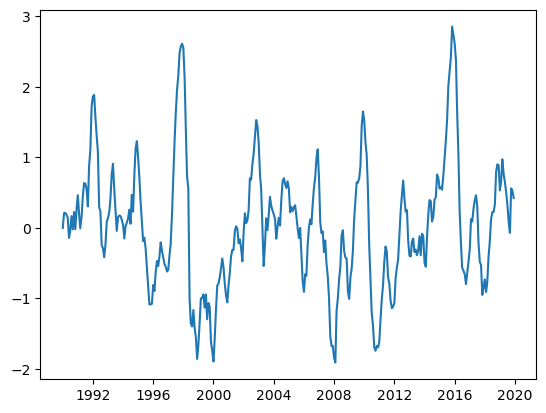

In [4]:
# plot ENSO data
plt.plot(ds_nino34['time'], ds_nino34['sst'])

### Definine and Plot ENSO Phases

El Nino:  41
Neutral:  274
La Nina:  45
[array(41), array(45), array(274)]


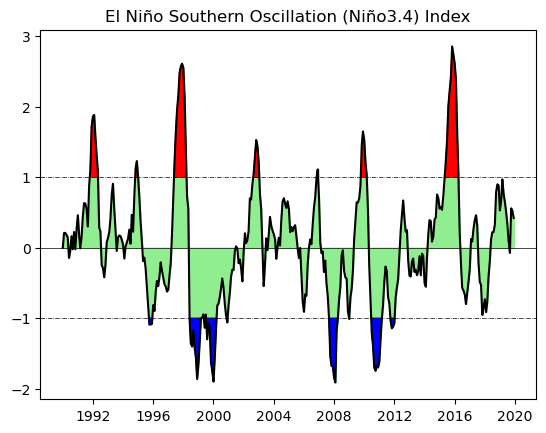

In [5]:
# Define El-Nino, La nina and neutral phases
elnino=ds_nino34['sst'].where(ds_nino34['sst']>=1)
lanina=ds_nino34['sst'].where(ds_nino34['sst']<=-1)
# neutral=ds_nino34['sst'].where(np.logical_and(ds_nino34['sst']>-1,
#                                               ds_nino34['sst']<1))

# Alternative to deducing the neutral
neutral = ds_nino34['sst'].where((ds_nino34['sst']>-1) & (ds_nino34['sst']<1))

print('El Nino: ',elnino.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

counts=[elnino.count(dim='time').values,
        lanina.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts)

plt.plot(ds_nino34['time'],ds_nino34['sst'],'k')
plt.fill_between(ds_nino34['time'].values,ds_nino34['sst'],color='lightgreen')
plt.fill_between(ds_nino34['time'].values,elnino,y2=1.0,color='red')
plt.fill_between(ds_nino34['time'].values,lanina,y2=-1.0,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(1,color='black',linewidth=0.5,linestyle='dashdot')#'dotted')
plt.axhline(-1,color='black',linewidth=0.5,linestyle='dashdot')#'dotted') 
plt.title('El Niño Southern Oscillation (Niño3.4) Index')

plt.savefig('/home/dadjei2/CLIM680/Project/figures/Niño3.4 phases.png', dpi=300)

### Load precipitation data used for the study

In [6]:
# load and read precipitation data
ds=xr.open_dataset('/home/dadjei2/CLIM680/Assignments/Africa_cru_data.nc')
# ds_pre = ds.sel(time=slice('1989-01-01', '2018-12-31'))
ds_pre = ds.sel(time=slice('1990-01-01', '2019-12-31'))
ds_pre

<xarray.Dataset> Size: 95MB
Dimensions:  (lon: 150, lat: 146, time: 360)
Coordinates:
  * lon      (lon) float32 600B -19.75 -19.25 -18.75 ... 53.75 54.25 54.75
  * lat      (lat) float32 584B -34.75 -34.25 -33.75 ... 36.75 37.25 37.75
  * time     (time) datetime64[ns] 3kB 1990-01-16 1990-02-15 ... 2019-12-16
Data variables:
    pre      (time, lat, lon) float32 32MB ...
    stn      (time, lat, lon) float64 63MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.05 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2103051243. Data generated from:pre.2103041709.dtb
    history:      Fri  5 Mar 14:41:58 GMT 2021 : User harry : Program makegri...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [7]:
# Slice array to be consistent with sst data
sliced_pre = ds_pre.pre.sel(time=slice(ds_nino34['time'][0],ds_nino34['time'][-1]))

pre_mean = sliced_pre.groupby('time.month').mean()
pre_anoms = sliced_pre.groupby('time.month')-pre_mean
# pre_anoms

In [8]:
# elnino_sst = pre_anoms.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')
# lanina_sst = pre_anoms.sel(time=lanina.dropna(dim='time')['time']).mean(dim='time')
# neutral_sst = pre_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

# comp_precip = [elnino_sst,lanina_sst,neutral_sst]
# comp_precip

In [9]:
# from scipy.stats import ttest_ind

# elnino_precip_vals = da_anoms.sel(time=elnino.dropna(dim='time')['time'])
# lanina_precip_vals = da_anoms.sel(time=lanina.dropna(dim='time')['time'])
# neutral_precip_vals = da_anoms.sel(time=neutral.dropna(dim='time')['time'])

### Select dates that match ENSO Phases

In [10]:
# Add dummy time values to align with monthly data
elnino_resampled = elnino.reindex(time=pre_anoms['time'], method='nearest')
lanina_resampled = lanina.reindex(time=pre_anoms['time'], method='nearest')
neutral_resampled = neutral.reindex(time=pre_anoms['time'], method='nearest')

elnino_pre = pre_anoms.sel(time=elnino_resampled.dropna(dim='time')['time']).mean(dim='time')
lanina_pre = pre_anoms.sel(time=lanina_resampled.dropna(dim='time')['time']).mean(dim='time')
neutral_pre = pre_anoms.sel(time=neutral_resampled.dropna(dim='time')['time']).mean(dim='time')

comp_precip = [elnino_pre,lanina_pre,neutral_pre]
comp_precip

[<xarray.DataArray 'pre' (lat: 146, lon: 150)> Size: 88kB
 array([[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 3.4148505, 4.2242417,
         5.243695 ],
        [      nan,       nan,       nan, ..., 3.1107936, 3.2994645,
         3.7174656],
        [      nan,       nan,       nan, ...,       nan, 3.5258021,
         3.7744825]], dtype=float32)
 Coordinates:
   * lon      (lon) float32 600B -19.75 -19.25 -18.75 ... 53.75 54.25 54.75
   * lat      (lat) float32 584B -34.75 -34.25 -33.75 ... 36.75 37.25 37.75,
 <xarray.DataArray 'pre' (lat: 146, lon: 150)> Size: 88kB
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan

In [11]:
#  ('nino', 'nina', 'neutral')

# precip_dict = {'nino':elnino_pre,
#               'nina':lanina_pre,
#               'neutral':neutral_pre}
# precip_dict

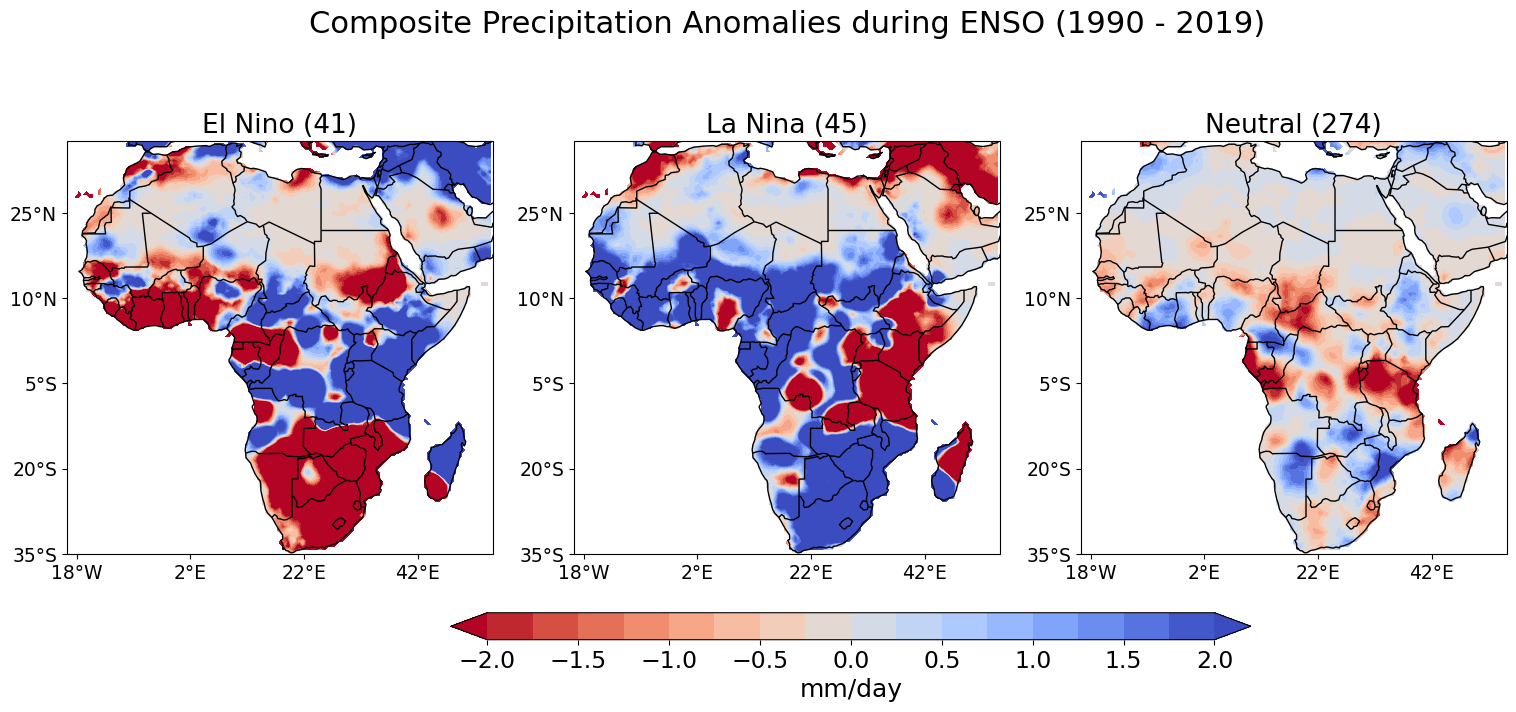

In [12]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,15))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm_r',extend='both')

    # Longitude labels
        # axs[i].set_xticks(np.arange(-17.75,54.75,30), crs=ccrs.PlateCarree())
        xticks = axs[i].set_xticks(np.arange(-18,55,20), crs=ccrs.PlateCarree())

        # Customize the font size of the y-tick labels
        axs[i].set_xticklabels(xticks, fontsize=13.5)
        
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        # axs[i].set_yticks(np.arange(-34.75,36.75,30), crs=ccrs.PlateCarree())
        yticks = axs[i].set_yticks(np.arange(-35,37 ,15), crs=ccrs.PlateCarree())
        
        # Customize the font size of the y-tick labels
        axs[i].set_yticklabels(yticks, fontsize=13.5)
        
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')', fontsize=19)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(features.BORDERS)

        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.19, hspace=-10.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.29, 0.38, 0.50, 0.018])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm')

# Increase tick label font size
cbar.ax.tick_params(labelsize=17)

# Increase the font size of the colorbar label
cbar.set_label('mm/day', fontsize=18)

# Add a big title at the top
plt.suptitle('Composite Precipitation Anomalies during ENSO (1990 - 2019)', fontsize=22, y=0.8);
plt.savefig('/home/dadjei2/CLIM680/Project/figures/CPA_ENSO(Composite).png', dpi=300)

### Composite plot

In [13]:
# calculating the difference
diff_precip=[elnino_pre-neutral_pre, 
             lanina_pre-neutral_pre]

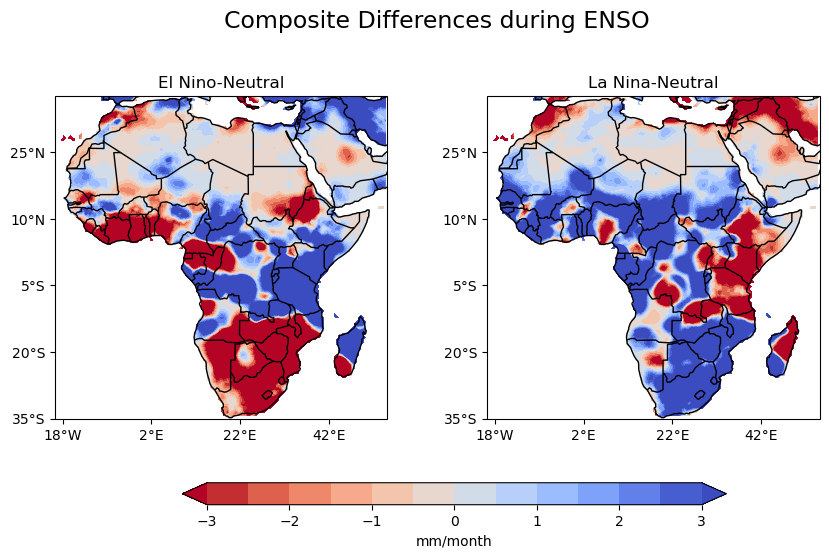

In [14]:
labels=['El Nino-Neutral','La Nina-Neutral']
clevs=np.arange(-3,3.5,0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(diff_precip):

        # Select the season
        data=diff_precip[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=diff_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm_r',extend='both')

       # Longitude labels
        # axs[i].set_xticks(np.arange(-17.75,54.75,30), crs=ccrs.PlateCarree())
        axs[i].set_xticks(np.arange(-18,55,20), crs=ccrs.PlateCarree())

        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        # axs[i].set_yticks(np.arange(-34.75,36.75,30), crs=ccrs.PlateCarree())
        axs[i].set_yticks(np.arange(-35,37 ,15), crs=ccrs.PlateCarree())

        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(features.BORDERS)

        
        # Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.31, top=0.9, left=0.05, right=0.95,
                    wspace=0.3, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
# cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar_ax = fig.add_axes([0.2, 0.38, 0.64, 0.02])


# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/month')

# Add a big title at the top
plt.suptitle('Composite Differences during ENSO', fontsize=17, y=0.83)
plt.savefig('/home/dadjei2/CLIM680/Project/figures/CDiff_ENSO(composite)',dpi=300)

In [15]:
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

In [16]:
from scipy.stats import ttest_ind

elnino_precip_vals = pre_anoms.sel(time=elnino_resampled.dropna(dim='time')['time'])
lanina_precip_vals = pre_anoms.sel(time=lanina_resampled.dropna(dim='time')['time'])
neutral_precip_vals = pre_anoms.sel(time=neutral_resampled.dropna(dim='time')['time'])


# Add dummy time values to align with daily data
# elnino_resampled = elnino.reindex(time=da_anoms['time'], method='nearest')
# lanina_resampled = lanina.reindex(time=da_anoms['time'], method='nearest')
# neutral_resampled = neutral.reindex(time=da_anoms['time'], method='nearest')

# elnino_sst = da_anoms.sel(time=elnino_resampled.dropna(dim='time')['time']).mean(dim='time')
# lanina_sst = da_anoms.sel(time=lanina_resampled.dropna(dim='time')['time']).mean(dim='time')
# neutral_sst = da_anoms.sel(time=neutral_resampled.dropna(dim='time')['time']).mean(dim='time')

# comp_precip = [elnino_sst,lanina_sst,neutral_sst]
# comp_precip

In [17]:
# elnino_sst

In [18]:
tstat,pval = ttest_ind(elnino_precip_vals, 
                neutral_precip_vals, 
                equal_var = False)

In [19]:
mask_diff = diff_precip[0].where(pval <= p)
mask_diff

<xarray.DataArray 'pre' (lat: 146, lon: 150)> Size: 88kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 3.802148 , 4.739092 ,
        5.9169893],
       [      nan,       nan,       nan, ..., 3.443826 , 3.680151 ,
        4.0961947],
       [      nan,       nan,       nan, ...,       nan, 3.9031057,
        4.1478443]], dtype=float32)
Coordinates:
  * lon      (lon) float32 600B -19.75 -19.25 -18.75 ... 53.75 54.25 54.75
  * lat      (lat) float32 584B -34.75 -34.25 -33.75 ... 36.75 37.25 37.75

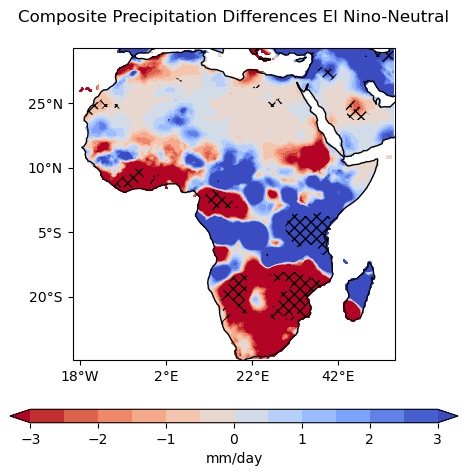

In [21]:
labels=['El Nino vs. Neutral']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=100)})
                                    # ccrs.PlateCarree(central_longitude=200.0)})


data=diff_precip[0]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_precip[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_precip[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='coolwarm_r',extend='both')

# axs[i].set_xticks(np.arange(-17.75,54.75,30), crs=ccrs.PlateCarree())
axs.set_xticks(np.arange(-18,55,20), crs=ccrs.PlateCarree())

lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
# axs[i].set_yticks(np.arange(-34.75,36.75,30), crs=ccrs.PlateCarree())
axs.set_yticks(np.arange(-35,37 ,15), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)

# Overlay of stippling
ss=axs.contourf(lons,diff_precip[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['xxx',''],extend='both',alpha=0.0)

# Draw the coastines for each subplot
axs.coastlines()
# axs.add_feature(features.BORDERS)
    
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.028])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences El Nino-Neutral')
plt.savefig('/home/dadjei2/CLIM680/Project/figures/Nino_Neutral(composite)',dpi=300)